# VAE

> Train a VAE to encode embeddings of normal behavior in the time series.

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [1]:
# | default_exp vae

In [2]:
# | export

# for configs
from hydra import compose, initialize
from omegaconf import OmegaConf
from fastcore.xtras import Path
import os

In [3]:
# run only once
try:
    initialize(config_path="../config", version_base="1.2")
    cfg = compose(config_name="config.yaml")
    cfg = OmegaConf.to_object(cfg)  # perform interpolation of the variables also
    cfg = OmegaConf.create(cfg)  # so that dot-notation works?
except Exception as e:
    print(f"Got Exception while reading config:\n{e}")

In [4]:
# | export

BASEDIR = Path(cfg.base_dir).resolve()
MODELDIR = Path(cfg.model_dir).resolve()
DATAPATH = Path(cfg.dataset.path).resolve()

print(f"Base directory: {BASEDIR}")
print(f"Model directory: {MODELDIR}")
print(f"Dataset is {DATAPATH}")

Base directory: /run/media/data2/ts_vae-lstm
Model directory: /run/media/data2/ts_vae-lstm/models
Dataset is /run/media/data2/ts_vae-lstm/sample_data/nyc_taxi.npz


In [5]:
# | export
num_workers = cfg.num_workers if cfg.get("num_workers", None) else os.cpu_count()
print(f"Number of workers: {num_workers}")

Number of workers: 4


In [6]:
# | export

device = cfg.device if cfg.device else ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [7]:
# | hide
from nbdev.showdoc import *

In [8]:
# | export

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import math

The program expects a <font color='#ff0000'>univariate time series</font> in a single file.

In [9]:
# | export

print(f"Reading {DATAPATH}")
if DATAPATH.name.endswith(".npz"):
    data = np.load(DATAPATH)
    print(data.keys())
elif DATAPATH.name.endswith(".csv"):
    data = pd.read_csv(DATAPATH)
    print(data.columns)
elif DATAPATH.name.endswith(".parquet"):
    data = pd.read_parquet(DATAPATH)
    print(data.columns)
else:
    raise NotImplementedError(
        f"Cannot read {DATAPATH}. Please raise an issue: thatgeeman/ts_vae-lstm"
    )

Reading /run/media/data2/ts_vae-lstm/sample_data/nyc_taxi.npz
KeysView(NpzFile '/run/media/data2/ts_vae-lstm/sample_data/nyc_taxi.npz' with keys: t, t_unit, readings, idx_anomaly, idx_split...)


Mean and standard deviations of training set.

In [10]:
# | export
TIMECOL = cfg.dataset.time_col
SIGNALCOL = cfg.dataset.signal
idx_split = cfg.dataset.idx_split

Read the anomaly indices:
- Used to validate the split of the data (thereby avoiding training on anomalous behaviour).
- Also used for visualization.

In [11]:
# | export
anomaly_idxs = cfg.dataset.get("idx_anomaly", None)
if anomaly_idxs is not None:
    assert (
        anomaly_idxs[0] > idx_split
    ), "Expected training set to contain only non-anomalous data"
else:
    print("No idx_anomaly set in config")

Read the columns defined in the config file and make train-test splits. Independent of the file format, the indexing should normally work.

In [12]:
# | export

data_train, data_test = data[SIGNALCOL][:idx_split], data[SIGNALCOL][idx_split:]

In [13]:
# | export

data_train.shape, data_test.shape

((5500,), (4820,))

In [14]:
# | export
train_m, train_std = data_train.mean(), data_train.std()
train_m, train_std

(15233.591636363637, 6780.169900027516)

Standardize the test dataset with the train mean and standard deviation.
The train fold will still be split later, so not standardizing it now.|

In [15]:
# | export

data_test_norm = (data_test - train_m) / (train_std + 1e-10)

In [16]:
# | export


def as_df(data):
    """Returns data as dataframe with the column named `value`."""
    return pd.DataFrame(data=data, columns=["value"])

In [17]:
as_df(data_train)

,value
0,10844.0
1,8127.0
2,6210.0
3,4656.0
4,3820.0
...,...
5495,19645.0
5496,20453.0
5497,19400.0
5498,18448.0


Check if the windows and number of steps look fine visually.

<Axes: xlabel='index', ylabel='value'>

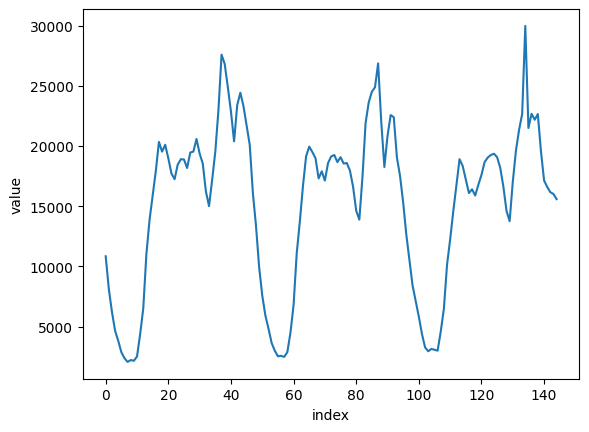

In [18]:
start_step = 0
p = 48  # for one full day
n_windows = 3
sns.lineplot(
    data=as_df(data_train[start_step : 1 + start_step + (p * n_windows)]).reset_index(),
    x="index",  # possible since we reset_index to add "index" column
    y="value",
)

# Gather data into structure

In [19]:
# | export

p = cfg.n_lag  # past sequences at time t. 48 steps = a day
end_steps = [es for es in range(p, len(data_train), 1)]
# step is one since we want overlapping windows for VAE training
len(end_steps), end_steps[:3], end_steps[-3:]

(5452, [48, 49, 50], [5497, 5498, 5499])

In [20]:
# | export

data_windowed = [
    {
        "subset": get_window(
            data_train,
            window_size=p,
            end_step=t,
            return_indices=False,
        ),
        "end_step": t,  # the time we want to predict for. For vae, we reconstruct the window.
        "start_step": t - p,
    }
    for t in end_steps
]

In [21]:
len(data_windowed), data_windowed[3]

(5452,
 {'subset': array([[ 4656.],
         [ 3820.],
         [ 2873.],
         [ 2369.],
         [ 2064.],
         [ 2221.],
         [ 2158.],
         [ 2515.],
         [ 4364.],
         [ 6526.],
         [11039.],
         [13857.],
         [15865.],
         [17920.],
         [20346.],
         [19539.],
         [20107.],
         [18984.],
         [17720.],
         [17249.],
         [18463.],
         [18908.],
         [18886.],
         [18178.],
         [19459.],
         [19546.],
         [20591.],
         [19380.],
         [18544.],
         [16228.],
         [15013.],
         [17203.],
         [19525.],
         [22966.],
         [27598.],
         [26827.],
         [24904.],
         [22875.],
         [20394.],
         [23401.],
         [24439.],
         [23318.],
         [21733.],
         [20104.],
         [16111.],
         [13370.],
         [ 9945.],
         [ 7571.]]),
  'end_step': 51,
  'start_step': 3})

Preseve 10% of the dataset from this for validation set.

In [22]:
# | export
split_ratio = cfg.test_split
val_data_idxs = np.random.choice(
    range(len(data_windowed)), size=int(split_ratio * len(data_windowed)), replace=False
)
trn_data_idxs = [idx for idx in range(len(data_windowed)) if idx not in val_data_idxs]
len(val_data_idxs), len(trn_data_idxs)

(1090, 4362)

In [23]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

In [24]:
# | export

val_data = [data_windowed[idx] for idx in val_data_idxs]
trn_data = [data_windowed[idx] for idx in trn_data_idxs]

Calculate stats over training data.

In [25]:
trn_data[0]["subset"].shape

(48, 1)

In [26]:
trn_data[0]

{'subset': array([[10844.],
        [ 8127.],
        [ 6210.],
        [ 4656.],
        [ 3820.],
        [ 2873.],
        [ 2369.],
        [ 2064.],
        [ 2221.],
        [ 2158.],
        [ 2515.],
        [ 4364.],
        [ 6526.],
        [11039.],
        [13857.],
        [15865.],
        [17920.],
        [20346.],
        [19539.],
        [20107.],
        [18984.],
        [17720.],
        [17249.],
        [18463.],
        [18908.],
        [18886.],
        [18178.],
        [19459.],
        [19546.],
        [20591.],
        [19380.],
        [18544.],
        [16228.],
        [15013.],
        [17203.],
        [19525.],
        [22966.],
        [27598.],
        [26827.],
        [24904.],
        [22875.],
        [20394.],
        [23401.],
        [24439.],
        [23318.],
        [21733.],
        [20104.],
        [16111.]]),
 'end_step': 48,
 'start_step': 0}

In [27]:
# | export

n_features = cfg.n_signals  # = 1, Since we have univariate time series.
n_features

1

In [28]:
# | export

assert (
    n_features == trn_data[0]["subset"].shape[1]
), f"Got {n_features} in config but {trn_data[0]['subset'].shape[1]} features in data!"

Find the train data mean and apply it to the validation data.

In [29]:
# | export

means = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
stds = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
slice_from = n_features - 1
for i, _trn_data in enumerate(trn_data):
    means[i] = (np.mean(_trn_data["subset"][:, slice_from:], axis=0)).astype(np.float32)
    stds[i] = (np.var(_trn_data["subset"][:, slice_from:], axis=0) ** 0.5).astype(
        np.float32
    )
means = means.mean(0)
stds = stds.mean(0)

means, stds

(array([15251.47511601]), array([6525.82856157]))

In [30]:
# | export


class TSDataset(Dataset):
    def __init__(self, data, mean, std):
        self.data = data
        self.mean = mean
        self.std = std

    def __getitem__(self, idx):
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        # ignore the timestamp column
        x = self.data[idx]["subset"][:, slice_from:]  # 1024, 4
        normed_X = ((x - self.mean) / (self.std + 1e-10)).astype(np.float32)
        return torch.as_tensor(normed_X)

    def __len__(self):
        return len(self.data)

In [31]:
# | export

dset_trn = TSDataset(trn_data, mean=means, std=stds)
dset_val = TSDataset(val_data, mean=means, std=stds)
# use same stats from training data

In [32]:
dset_trn[0].shape

torch.Size([48, 1])

In [33]:
len(dset_trn)

4362

In [34]:
# | export

batch_size = cfg.batch_sz
drop_last = cfg.drop_last

In [35]:
# | export

dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=drop_last,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=drop_last,
    shuffle=False,
    num_workers=num_workers,
)

In [36]:
xs = next(iter(dl_trn))
xs.shape

torch.Size([8, 48, 1])

In [37]:
xs.shape

torch.Size([8, 48, 1])

## Defining Encoder

In [38]:
num_hidden_units = cfg.num_hidden_units
kernel_size = cfg.kernel_size, n_features
stride = cfg.stride, n_features
latent_dim = cfg.latent_dim
kernel_size, stride

((5, 1), (2, 1))

In [39]:
xs_c1 = nn.Conv2d(
    in_channels=n_features,
    out_channels=num_hidden_units // 8,
    kernel_size=kernel_size,
    stride=stride,
)(xs.unsqueeze(1))
xs_c2 = nn.Conv2d(
    in_channels=num_hidden_units // 8,
    out_channels=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c1)
xs_c1.shape, xs_c2.shape  # , xs_c3.shape, xs_c4.shape

(torch.Size([8, 64, 22, 1]), torch.Size([8, 512, 9, 1]))

In [40]:
# | export

# encoder
# l_win to 24, the model would consider each 24-hour period as one sequence.
# pad: if your array is [1, 2, 3] and you symmetrically pad it with 1 unit, the result would be [2, 1, 2, 3, 2].
# xavier_initializer()
# conv 1: num_hidden_units / 16
# conv 2: num_hidden_units / 8
# conv 3: num_hidden_units / 4
# conv 4: num_hidden_units / 1, kernel = 4, 1
# padding : same


class Encoder(nn.Module):
    def __init__(
        self,
        latent_dim=20,
        num_hidden_units=512,
        kernel_size=5,
        stride=2,
        act=F.mish,
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(
            in_channels=n_features,
            out_channels=num_hidden_units // 8,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_hidden_units // 8,
            out_channels=num_hidden_units,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.bn1 = nn.BatchNorm2d(num_hidden_units // 8)
        self.bn2 = nn.BatchNorm2d(num_hidden_units)

        self.linear = nn.LazyLinear(
            out_features=num_hidden_units,
            bias=False,
        )
        self.linear_mean = nn.LazyLinear(
            out_features=latent_dim,
            bias=False,
        )
        self.linear_var = nn.LazyLinear(
            out_features=latent_dim,
            bias=False,
        )
        self.act = act
        self.init_weights()

    def forward(self, x):
        x = x.unsqueeze(1)  # 100, 1, 48, 1
        x = self.act(self.bn1(self.conv1(x)))  # 100, 32, 23, 1
        x = self.act(self.bn2(self.conv2(x)))  # 100, 64, 11, 1
        x = self.flatten(x)  # 100, 512
        x = self.act(self.linear(x))  # 100, 512
        z_mean = self.linear_mean(x)
        z_log_var = self.linear_var(x)
        return z_mean, z_log_var

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)

In [41]:
emb_mean, emb_var = Encoder(
    latent_dim=latent_dim,
    num_hidden_units=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
)(xs)
emb_mean.shape, emb_var.shape

/home/gg/.local/share/virtualenvs/ts_vae-lstm-hz-Oy2CQ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([8, 24]), torch.Size([8, 24]))

In [42]:
emb_mean.mean(), emb_var.mean()

(tensor(0.0138, grad_fn=<MeanBackward0>),
 tensor(0.0112, grad_fn=<MeanBackward0>))

## Defining Sampler 

In [43]:
# | export


class StochasticSampler(nn.Module):
    """We basically want to parametrize the sampling from the latent space"""

    def __init__(self, deterministic=False):
        super().__init__()
        self.sampler = torch.distributions.Normal(loc=0, scale=1)
        self.deterministic = deterministic

    def forward(self, z_mean, z_log_var):
        """Return a normal sample value Z from the latent space given a mean and variance"""
        # z_mean and z_log_var are mean and log-var estimates of the latent space
        # under the assumption that the latent space is a gaussian normal
        device = z_mean.device
        # Scales and shifts the sampled values using the reparameterization trick
        eps = self.sampler.sample(z_mean.shape).squeeze().to(device)
        # print(eps.shape, z_log_var.shape, z_mean.shape)
        return (
            z_mean
            if self.deterministic
            else (z_mean + torch.exp(0.5 * z_log_var) * eps)
        )

In [44]:
sampler = StochasticSampler(deterministic=False)
emb = sampler(emb_mean, emb_var)
emb.shape, emb.requires_grad, emb[0]

(torch.Size([8, 24]),
 True,
 tensor([-0.4913, -1.6761,  0.4892,  1.0128,  0.5840,  0.4927,  0.4548, -1.3511,
          1.7965,  1.5238,  0.6137, -1.2988,  0.9737,  1.3290,  0.0090,  1.2912,
          1.1622,  2.2085, -0.5597, -0.3004,  0.4010,  1.3658, -0.1288, -0.0282],
        grad_fn=<SelectBackward0>))

It's called the reparameterization trick because it reparameterizes the sampling process into a deterministic function that can be used for backpropagation. The core idea is to introduce an epsilon term drawn from a standard normal distribution and combine it with the mean and log variance of the latent distribution in a specific way. This allows the model to learn the parameters of the latent distribution (mean and variance) while still maintaining the stochastic nature of sampling during training.

## Defining Decoder part

In [45]:
xs_c1 = nn.Linear(in_features=latent_dim, out_features=num_hidden_units, bias=False)(
    emb
)
xs_c1 = xs_c1[:, :, None, None]
xs_c2 = nn.ConvTranspose2d(
    in_channels=num_hidden_units,
    out_channels=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c1)
xs_c3 = nn.ConvTranspose2d(
    in_channels=num_hidden_units,
    out_channels=num_hidden_units // 8,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c2)
xs_c3 = nn.Flatten()(xs_c2)
xs_c4 = nn.LazyLinear(out_features=p, bias=False)(xs_c3)
(
    xs_c1.shape,
    xs_c2.shape,
    xs_c3.shape,
    xs_c4.shape,
)

(torch.Size([8, 512, 1, 1]),
 torch.Size([8, 512, 5, 1]),
 torch.Size([8, 2560]),
 torch.Size([8, 48]))

In [46]:
# | export


# l_win to 24, the model would consider each 24-hour period as one sequence.
# pad: if your array is [1, 2, 3] and you symmetrically pad it with 1 unit, the result would be [2, 1, 2, 3, 2].
# xavier_initializer()
# dense 1: num_hidden_units
# reshape: (bs, 1, 1, num_hidden_units)  -> this is tensorflow notation, channel at end so actually (bs, num_hidden_units, 1, 1)

# conv 2: num_hidden_units, kernel = 1
# reshape: (bs, 4, 1, num_hidden_units / 4)

# conv 3: num_hidden_units / 4, kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, 8, 1, num_hidden_units / 8),

# conv 4: num_hidden_units / 8,  kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, 16, 1, num_hidden_units / 16)

# conv 5: num_hidden_units / 16, kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, num_hidden_units /16, 1,  16)

# conv 6: num_channel, kernel = 9, 1, stride = 1
# reshape: (bs, l_win, num_channel)


class Decoder(nn.Module):
    def __init__(
        self,
        output_shape,
        latent_dim=20,
        num_hidden_units=512,
        kernel_size=5,
        stride=2,
        act=F.mish,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.linear = nn.Linear(
            in_features=latent_dim, out_features=num_hidden_units, bias=False
        )
        self.dconv1 = nn.ConvTranspose2d(
            in_channels=num_hidden_units,
            out_channels=num_hidden_units,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.dconv2 = nn.ConvTranspose2d(
            in_channels=num_hidden_units,
            out_channels=num_hidden_units // 8,
            kernel_size=kernel_size,
            stride=stride,
        )

        self.bn1 = nn.BatchNorm2d(num_hidden_units)
        self.bn2 = nn.BatchNorm2d(num_hidden_units // 8)

        self.flatten = nn.Flatten()
        self.linear_out = nn.LazyLinear(
            out_features=math.prod(output_shape),
            bias=False,
        )

        self.act = act

        self.init_weights()

    def forward(self, x):
        x = self.linear(x)
        x = x[:, :, None, None]
        x = self.act(self.bn1(self.dconv1(x)))
        x = self.act(self.bn2(self.dconv2(x)))
        x = self.flatten(x)
        # no act for last layer
        x = self.linear_out(x)
        return self.reshape_to_output(x)

    def reshape_to_output(self, x):
        bs = x.shape[0]
        return x.reshape(bs, *self.output_shape)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)

In [48]:
Decoder(
    output_shape=(p, n_features),
    latent_dim=latent_dim,
    num_hidden_units=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
)(emb).shape

/home/gg/.local/share/virtualenvs/ts_vae-lstm-hz-Oy2CQ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([8, 48, 1])

In [49]:
xs.shape

torch.Size([8, 48, 1])

In [50]:
xs.size(1)

48

In [51]:
# | export
class VAE(nn.Module):
    def __init__(
        self,
        input_shape,
        latent_dim=20,
        num_hidden_units=512,
        kernel_size=5,
        stride=2,
        act=F.leaky_relu,
        deterministic=False,
    ):
        super().__init__()
        self.encoder = Encoder(
            latent_dim=latent_dim,
            act=act,
            num_hidden_units=num_hidden_units,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.decoder = Decoder(
            output_shape=input_shape,
            latent_dim=latent_dim,
            act=act,
            num_hidden_units=num_hidden_units,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.latent_sampler = StochasticSampler(deterministic=deterministic)
        self.act = act

    def forward(self, x):
        # x shape: [batch_size, sequence_length, num_features]
        z_mean, z_log_var = self.encoder(x)
        z = self.latent_sampler(z_mean, z_log_var)
        reconstructed_x = self.decoder(z)
        # loss to enforce all possible values are sampled from latent space
        # should be of the size of the batch

        # Reconstruction Loss (Mean Squared Error)
        reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction="mean")
        loss_kl = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        # / x.size(1)
        # average the KL divergence across the batch dimension
        # In the VAE-LSTM paper, they mention normalizing the KL divergence term by the number of features in the input.
        vae_loss = reconstruction_loss + loss_kl
        return reconstructed_x, vae_loss

In [52]:
xs.shape

torch.Size([8, 48, 1])

In [53]:
kernel_size

(5, 1)

In [54]:
model = VAE(
    input_shape=(p, n_features),
    latent_dim=latent_dim,
    num_hidden_units=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
)
xs_pred, loss = model(xs)

loss

tensor(1.3158, grad_fn=<AddBackward0>)

In [55]:
xs_pred.shape, loss

(torch.Size([8, 48, 1]), tensor(1.3158, grad_fn=<AddBackward0>))

# Evaluation metric

In [56]:
# | export


@torch.no_grad()
def evaluate_reconstruction(original_signal, reconstructed_signal):
    """
    Evaluates the quality of the reconstructed signal compared to the original signal.

    Args:
        original_signal (torch.Tensor): Original time series signal.
        reconstructed_signal (torch.Tensor): Reconstructed signal from the VAE.

    Returns:
        dict: Dictionary containing the evaluation metrics:
            - mse: Mean Squared Error
            - mae: Mean Absolute Error
    """

    # Ensure tensors are on the CPU and numpy arrays
    original_signal = original_signal.cpu().numpy()
    reconstructed_signal = reconstructed_signal.cpu().numpy()

    # Mean Squared Error
    mse = nn.MSELoss()(
        torch.from_numpy(original_signal), torch.from_numpy(reconstructed_signal)
    ).item()

    # Mean Absolute Error
    mae = nn.L1Loss()(
        torch.from_numpy(original_signal), torch.from_numpy(reconstructed_signal)
    ).item()

    return {
        "mse": mse,
        "mae": mae,
    }

# Training loop

In [57]:
# | export


def validate_epoch(dls, scorer):
    """For the full dataloader, calculate the running loss and score"""
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    with torch.no_grad():
        for batch_idx, xs in enumerate(dls):
            # move to device
            xs = xs.to(device)

            # Forward pass
            xs_gen, loss = model(xs)
            # calc score
            score = scorer(xs, xs_gen)["mse"]

            running_loss += loss.item()
            running_score += score
    return running_loss / len(dls), running_score / len(dls)

In [58]:
# | export

from fastcore.xtras import partial
import time

In [59]:
train = True
batch_size = cfg.batch_sz
# range_of_vals = 3.5  # output values will be in the range -3 to 3
activation = F.mish
latent_dim = latent_dim  # int(p * n_features // 2)
learning_rate = cfg.lr
num_epochs = cfg.epochs

dset_trn = TSDataset(trn_data, mean=means, std=stds)
dset_val = TSDataset(val_data, mean=means, std=stds)
dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=train,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    num_workers=num_workers,
)

#
train_dataloader = dl_trn
valid_dataloader = dl_val
print_every = len(train_dataloader)  # epoch number to print at

print(f"latent_dim is {latent_dim}")
model = VAE(
    latent_dim=latent_dim,
    input_shape=(p, n_features),
    act=activation,
    num_hidden_units=num_hidden_units,
    kernel_size=kernel_size,
    stride=stride,
).to(device)  # to make visualization easier, 2 latent dims

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=cfg.wd)
scorer = evaluate_reconstruction  # calculate_smape
# Training loop

# Define LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=cfg.factor, patience=cfg.patience, min_lr=1e-8, verbose=True
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    for batch_idx, xs in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        # move to device
        xs = xs.to(device)

        # Forward pass
        xs_gen, loss = model(xs)
        # calc score
        score = scorer(xs_gen, xs)["mse"]

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += score

    if (batch_idx + 1) % print_every == 0:
        # calculate loss for valid_dataloader
        n_dls = len(train_dataloader)
        val_loss, val_score = validate_epoch(valid_dataloader, scorer)
        print(
            "Epoch [{}/{}], Batch [{}/{}], Loss: [{:.3f}, {:.3f}], Score: [{:.3f}, {:.3f}]".format(
                epoch + 1,
                num_epochs,
                batch_idx + 1,
                n_dls,
                running_loss / n_dls,
                val_loss,
                running_score / n_dls,
                val_score,
            )
        )
    # reset at end of epoch
    running_loss = 0.0
    running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss)  # min the running_loss

latent_dim is 24
Epoch [1/50], Batch [545/545], Loss: [0.566, 0.460], Score: [0.342, 0.278]
Epoch [2/50], Batch [545/545], Loss: [0.430, 0.382], Score: [0.240, 0.204]
Epoch [3/50], Batch [545/545], Loss: [0.394, 0.388], Score: [0.213, 0.206]
Epoch [4/50], Batch [545/545], Loss: [0.366, 0.349], Score: [0.193, 0.177]
Epoch [5/50], Batch [545/545], Loss: [0.352, 0.343], Score: [0.184, 0.165]
Epoch [6/50], Batch [545/545], Loss: [0.337, 0.329], Score: [0.173, 0.170]
Epoch [7/50], Batch [545/545], Loss: [0.335, 0.325], Score: [0.170, 0.139]
Epoch [8/50], Batch [545/545], Loss: [0.329, 0.319], Score: [0.169, 0.180]
Epoch [9/50], Batch [545/545], Loss: [0.324, 0.307], Score: [0.167, 0.169]
Epoch [10/50], Batch [545/545], Loss: [0.316, 0.302], Score: [0.160, 0.143]
Epoch [11/50], Batch [545/545], Loss: [0.312, 0.299], Score: [0.158, 0.155]
Epoch [12/50], Batch [545/545], Loss: [0.306, 0.293], Score: [0.153, 0.142]
Epoch [13/50], Batch [545/545], Loss: [0.306, 0.326], Score: [0.150, 0.159]
Epoc

In [60]:
time_slug = int(time.time())
time_slug

1732462904

In [61]:
model_pth = f"{MODELDIR}/vae_{num_epochs}_z{latent_dim}_{time_slug}.pth"
model_pth

'/run/media/data2/ts_vae-lstm/models/vae_50_z24_1732462904.pth'

In [62]:
# save to path
torch.save(model, model_pth)

# Inference

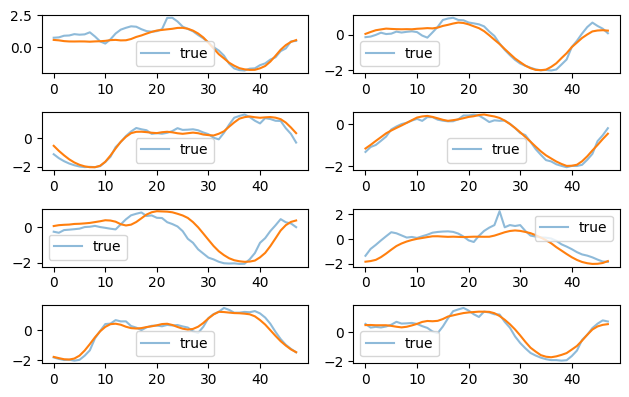

In [63]:
model = torch.load(model_pth)
with torch.no_grad():
    xs_val = next(iter(dl_val))
    xs_val_gen, loss_kl = model(xs_val.to(device))

for idx in range(batch_size):
    if idx >= 10:
        break
    plt.subplot(5, 2, idx + 1)
    idx_feature = 0
    decoded_example, actual_example = (
        xs_val_gen[idx].detach().cpu(),
        xs_val[idx].detach().cpu(),
    )
    sns.lineplot(
        actual_example[:, idx_feature].numpy(),
        alpha=0.5,
        label="true",
    )
    sns.lineplot(decoded_example[:, idx_feature].numpy())  # , label="vae")
plt.tight_layout()

# Display embedding

In [64]:
with torch.no_grad():
    xs_val = next(iter(dl_val))
    emb_mean_val, emb_std_val = model.encoder(xs_val.to(device))
    emb_val = model.latent_sampler(emb_mean_val, emb_std_val)

In [65]:
emb_val.cpu().numpy().shape

(8, 24)

<Axes: xlabel='None', ylabel='None'>

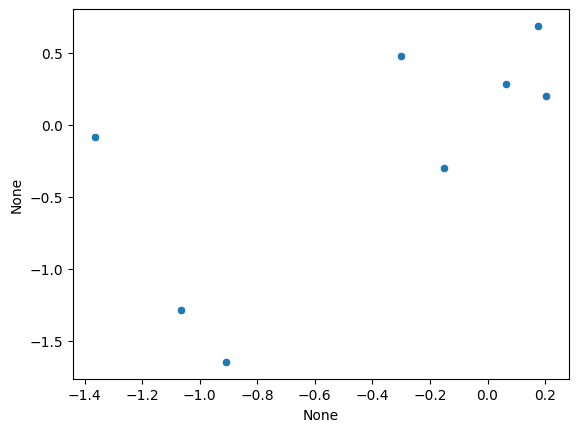

In [66]:
sns.scatterplot(x=emb_val[:, 0].cpu(), y=emb_val[:, 2].cpu())

In [67]:
# | hide
import nbdev

nbdev.nbdev_export()